In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'config_score.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'gdelt', 'storage_dir': '../data/', 'embedding_config': './embedding_config.json', 'criteria': 'score', 'train_ratio': 0.3, 'hidden_dim': 256, 'max_hops': 6, 'num_neg': 3, 'num_threads': 2, 'decay_factor': 0.2, 'max_fanout': 100, 'beam_width': 20, 'max_epochs': 1, 'batch_size': 8, 'dim_feedforward': 256, 'nhead': 4, 'num_layers': 6, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 0, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph'}


In [2]:
tqdm.pandas()

In [3]:
import os, requests, json, pprint

cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
assert cid and key, "Not running on a Vast.ai container!"

resp = requests.get(
    f"https://console.vast.ai/api/v0/instances/{cid}/",
    headers={"Authorization": f"Bearer {key}",
             "accept": "application/json"},
    timeout=10,
)

info = resp.json()
print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
# print(info['instances'].keys())

Effective vCPUs: 24.0


In [4]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train


IOStream.flush timed out


Negative paths file not found for train split: ../data/transe_gdelt_train_neg.json. Skipping negative paths setup.
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 6076360 edges in train split...


Scanning edges: 100%|██████████| 6076360/6076360 [00:10<00:00, 601985.89it/s]



Pre-scan Results for train:
  Total edges scanned: 6076360
  Valid edges (has pos & neg paths): 5347630 (88.0%)
  Missing positive paths: 728730 (12.0%)
  Missing negative paths: 6076360 (100.0%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 5347630 valid edges.
  New edge count for train: 5347630
--- Pre-scan complete ---

Use shallow embeddings: True at config ./embedding_config.json
Loaded 5347630 edges for train split.
Setting up data for split: valid
Negative paths file not found for valid split: ../data/transe_gdelt_valid_neg.json. Skipping negative paths setup.
Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./embedding_config.json
Loaded 1193825 edges for valid split.
Setting up data for split: test
Negative paths file not found for test split: ../data/transe_gdelt_test_neg.json. Skipping negative paths setup.
Pre-scan not configured for te

In [5]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'test'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'valid' split...


In [6]:
print(len(pos_paths), len(neg_paths))

1151003 0


In [7]:
edges_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193825 entries, 7114614 to 8308438
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   feat_pos_u  1193825 non-null  int64
 1   feat_pos_v  1193825 non-null  int64
 2   u           1193825 non-null  int64
 3   v           1193825 non-null  int64
 4   u_type      1193825 non-null  int64
 5   v_type      1193825 non-null  int64
 6   ts          1193825 non-null  int64
 7   split       1193825 non-null  int64
 8   label       1193825 non-null  int64
 9   edge_type   1193825 non-null  int64
 10  v_pos       1193825 non-null  int64
dtypes: int64(11)
memory usage: 109.3 MB


In [8]:
edges_df[edges_df['v_pos'] == edges_df['v']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 477530 entries, 7114614 to 8307349
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  477530 non-null  int64
 1   feat_pos_v  477530 non-null  int64
 2   u           477530 non-null  int64
 3   v           477530 non-null  int64
 4   u_type      477530 non-null  int64
 5   v_type      477530 non-null  int64
 6   ts          477530 non-null  int64
 7   split       477530 non-null  int64
 8   label       477530 non-null  int64
 9   edge_type   477530 non-null  int64
 10  v_pos       477530 non-null  int64
dtypes: int64(11)
memory usage: 43.7 MB


In [9]:
edges_df[edges_df['v_pos'] == edges_df['v']].describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
count,477530.000000,477530.000000,477530.000000,477530.000000,477530.0,477530.0,477530.000000,477530.0,477530.0,477530.000000,477530.000000
mean,453.883434,453.883434,453.883434,453.883434,0.0,0.0,36454.059703,2.0,1.0,143.881511,453.883434
std,738.651641,738.651641,738.651641,738.651641,0.0,0.0,1163.580018,0.0,0.0,123.065046,738.651641
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,34560.000000,2.0,1.0,0.000000,0.000000
25%,52.000000,52.000000,52.000000,52.000000,0.0,0.0,35490.000000,2.0,1.0,17.000000,52.000000
50%,187.000000,187.000000,187.000000,187.000000,0.0,0.0,36345.000000,2.0,1.0,239.000000,187.000000
75%,546.000000,546.000000,546.000000,546.000000,0.0,0.0,37365.000000,2.0,1.0,257.000000,546.000000
max,7397.000000,7397.000000,7397.000000,7397.000000,0.0,0.0,38865.000000,2.0,1.0,478.000000,7397.000000


In [10]:
edges_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u    v_pos edge_type ts                                                        
0    1     34        35475           4           4  4       4       4      4   
           36        35475           4           4  4       4       4      4   
           274       35475           1           1  1       1       1      1   
     2     0         36210           4           4  4       4       4      4   
           2         34575           4           4  4       4       4      4   
...                                ...         ... ..     ...     ...    ...   
7394 1874  256       38730           1           1  1       1       1      1   
7395 1020  63        38805           4           4  4       4       4      4   
           303       38805           1           1  1       1       1      1   
7396 218   18        38850           4           4  4       4       4      4   
7397 27    291       38850           1           1  1       1       1      1   

                            label  
u    v_pos edge_type ts            
0    1     34        35475      4  
           36        35475      4  
           274       35475      1  
     2     0         36210      4  
           2         34575      4  
...                           ...  
7394 1874  256       38730      1  
7395 1020  63        38805      4  
           303       38805      1  
7396 218   18        38850      4  
7397 27    291       38850      1  

[477530 rows x 7 columns]

In [11]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']
    u = row['u']
    v = row['v']
    ts = row['ts']
    v_pos = row['v_pos']
    edge_type = row['edge_type']
    edge_meta = {}

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        edge_meta = {
            'path_length': pos_path_len,
            # 'path_type': 'positive',
            'label': label,
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
            
        }
    else:
        edge_meta = {
            'path_length': 0,
            # 'path_type': 'positive',
            'label': label,
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
        }

    # # Process negative paths
    # if eid_str in neg_paths:
    #     # for neg_path_interleaved in neg_paths[eid_str]:
    #     #     # As per loader.py, nodes are at even indices
    #     #     neg_path_len = len(neg_path_interleaved[::2])
    #     #     plot_data.append({
    #     #         'path_length': neg_path_len,
    #     #         'path_type': 'negative',
    #     #         'label': 'true_link' if label == 1 else 'false_link'
    #     #     })
    #     edge_meta["num_neg"] = len(neg_paths[eid_str])

    plot_data.append(edge_meta)

Extracting paths: 100%|██████████| 1193825/1193825 [00:39<00:00, 30143.76it/s]


In [12]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


In [13]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193825 entries, 0 to 1193824
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   path_length  1193825 non-null  int64
 1   label        1193825 non-null  int64
 2   u            1193825 non-null  int64
 3   v            1193825 non-null  int64
 4   ts           1193825 non-null  int64
 5   edge_type    1193825 non-null  int64
 6   v_pos        1193825 non-null  int64
dtypes: int64(7)
memory usage: 63.8 MB


In [14]:
edges_fp = os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_edges.csv")
df = pd.read_csv(edges_fp, index_col='edge_id')            
split_map = {str(idx): row['split'] for idx, row in tqdm(df.iterrows())}

9834644it [03:27, 47295.66it/s]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9834644 entries, 0 to 9834643
Data columns (total 11 columns):
 #   Column      Dtype
---  ------      -----
 0   feat_pos_u  int64
 1   feat_pos_v  int64
 2   u           int64
 3   v           int64
 4   u_type      int64
 5   v_type      int64
 6   ts          int64
 7   split       int64
 8   label       int64
 9   edge_type   int64
 10  v_pos       int64
dtypes: int64(11)
memory usage: 900.4 MB


In [16]:
df[(df['v_pos'] == df['v']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 610482 entries, 8308439 to 9832072
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  610482 non-null  int64
 1   feat_pos_v  610482 non-null  int64
 2   u           610482 non-null  int64
 3   v           610482 non-null  int64
 4   u_type      610482 non-null  int64
 5   v_type      610482 non-null  int64
 6   ts          610482 non-null  int64
 7   split       610482 non-null  int64
 8   label       610482 non-null  int64
 9   edge_type   610482 non-null  int64
 10  v_pos       610482 non-null  int64
dtypes: int64(11)
memory usage: 55.9 MB


In [17]:
df[(df['label'] == 1) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 610482 entries, 8308439 to 9832072
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  610482 non-null  int64
 1   feat_pos_v  610482 non-null  int64
 2   u           610482 non-null  int64
 3   v           610482 non-null  int64
 4   u_type      610482 non-null  int64
 5   v_type      610482 non-null  int64
 6   ts          610482 non-null  int64
 7   split       610482 non-null  int64
 8   label       610482 non-null  int64
 9   edge_type   610482 non-null  int64
 10  v_pos       610482 non-null  int64
dtypes: int64(11)
memory usage: 55.9 MB


In [18]:
df[(df['v_pos'] == df['u']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  0 non-null      int64
 1   feat_pos_v  0 non-null      int64
 2   u           0 non-null      int64
 3   v           0 non-null      int64
 4   u_type      0 non-null      int64
 5   v_type      0 non-null      int64
 6   ts          0 non-null      int64
 7   split       0 non-null      int64
 8   label       0 non-null      int64
 9   edge_type   0 non-null      int64
 10  v_pos       0 non-null      int64
dtypes: int64(11)
memory usage: 0.0 bytes


In [19]:
df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u    v_pos edge_type ts                                                        
0    1     0         0               1           1  1       1       1      1   
                     3375            1           1  1       1       1      1   
           7         4935            1           1  1       1       1      1   
           12        3750            1           1  1       1       1      1   
           24        25485           4           4  4       4       4      4   
...                                ...         ... ..     ...     ...    ...   
7687 253   9         44565           4           4  4       4       4      4   
7688 547   3         44580           4           4  4       4       4      4   
           242       44580           1           1  1       1       1      1   
7689 27    7         44580           4           4  4       4       4      4   
7690 180   7         44625           4           4  4       4       4      4   

                            label  
u    v_pos edge_type ts            
0    1     0         0          1  
                     3375       1  
           7         4935       1  
           12        3750       1  
           24        25485      4  
...                           ...  
7687 253   9         44565      4  
7688 547   3         44580      4  
           242       44580      1  
7689 27    7         44580      4  
7690 180   7         44625      4  

[4556810 rows x 7 columns]

In [20]:
df[df["split"] == 2].groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u    v_pos edge_type ts                                                        
0    1     34        35475           4           4  4       4       4      4   
           36        35475           4           4  4       4       4      4   
           274       35475           1           1  1       1       1      1   
     2     0         36210           4           4  4       4       4      4   
           2         34575           4           4  4       4       4      4   
...                                ...         ... ..     ...     ...    ...   
7394 1874  256       38730           1           1  1       1       1      1   
7395 1020  63        38805           4           4  4       4       4      4   
           303       38805           1           1  1       1       1      1   
7396 218   18        38850           4           4  4       4       4      4   
7397 27    291       38850           1           1  1       1       1      1   

                            label  
u    v_pos edge_type ts            
0    1     34        35475      4  
           36        35475      4  
           274       35475      1  
     2     0         36210      4  
           2         34575      4  
...                           ...  
7394 1874  256       38730      1  
7395 1020  63        38805      4  
           303       38805      1  
7396 218   18        38850      4  
7397 27    291       38850      1  

[477530 rows x 7 columns]

In [21]:
# len(split_map.keys())

In [22]:
# list(split_map.values())[-1]

In [23]:
# split_code = {'pre': 0, 'train': 1, 'valid': 2, 'test': 3}

# print(f"Setting up data for split: {split}")

# pos_paths = {}
# with open(os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_paths.txt")) as f:
#     n_str = f.readline()
#     n = int(n_str) if n_str and n_str.strip() else 0
#     for _ in tqdm(range(n)):
#         eid = f.readline().strip()
#         if not eid:
#             break
#         hops = int(f.readline())
#         nodes = [int(u) for u in f.readline().split()]
#         node_types = [int(t) for t in f.readline().split()]
#         edge_types_str = f.readline().strip().split()
#         edge_types = [int(et) for et in edge_types_str if et]
        
#         edge_timestamps_str = f.readline().strip().split()
#         edge_timestamps = [int(ts) for ts in edge_timestamps_str if ts]

#         if split_map.get(eid) == split_code[split]:
#             pos_paths[eid] = {
#                 "hops": hops,
#                 "nodes": nodes,
#                 "node_types": node_types,
#                 "edge_types": edge_types,
#                 "edge_timestamps": edge_timestamps
#             }


In [24]:
# len(pos_paths.keys())

In [25]:
plot_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,1,60,42,34560,24,42
1,2,1,270,60,34560,45,60
2,2,1,270,60,34560,19,60
3,2,1,60,41,34560,17,41
4,3,1,270,851,34560,71,851
...,...,...,...,...,...,...,...
1193820,3,0,27,6185,38865,76,2226
1193821,3,0,27,6406,38865,76,2226
1193822,3,0,512,2179,38865,6,115
1193823,3,0,512,4197,38865,6,115


In [26]:
pos_df = plot_df[plot_df["path_length"] > 0].copy()
pos_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,1,60,42,34560,24,42
1,2,1,270,60,34560,45,60
2,2,1,270,60,34560,19,60
3,2,1,60,41,34560,17,41
4,3,1,270,851,34560,71,851
...,...,...,...,...,...,...,...
1193819,4,0,27,6464,38865,76,2226
1193820,3,0,27,6185,38865,76,2226
1193821,3,0,27,6406,38865,76,2226
1193822,3,0,512,2179,38865,6,115


In [27]:
temp = pos_df[pos_df["label"] == 1].groupby("path_length").count()
temp

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,314394,314394,314394,314394,314394,314394
3,161423,161423,161423,161423,161423,161423
4,846,846,846,846,846,846
5,39,39,39,39,39,39


In [28]:
temp / temp.sum() * 100

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,65.951894,65.951894,65.951894,65.951894,65.951894,65.951894
3,33.862455,33.862455,33.862455,33.862455,33.862455,33.862455
4,0.177469,0.177469,0.177469,0.177469,0.177469,0.177469
5,0.008181,0.008181,0.008181,0.008181,0.008181,0.008181


In [29]:
pos_df[pos_df["label"] == 0].groupby("path_length").count()

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
3,469599,469599,469599,469599,469599,469599
4,193088,193088,193088,193088,193088,193088
5,11553,11553,11553,11553,11553,11553
6,60,60,60,60,60,60
7,1,1,1,1,1,1


In [30]:
plot_df[plot_df["path_length"] < 2]

,path_length,label,u,v,ts,edge_type,v_pos
1440,0,1,7146,700,34560,10,700
3537,0,1,700,7146,34560,250,7146
4198,0,0,270,7431,34560,45,60
4201,0,0,270,7431,34560,19,60
4242,0,0,2147,7358,34560,23,583
...,...,...,...,...,...,...,...
1193803,0,0,394,7646,38865,34,26
1193809,0,0,27,7580,38865,79,26
1193813,0,0,512,7588,38865,19,160
1193815,0,0,512,7473,38865,19,160


In [31]:
def calculate_metrics(group):
    """
    Calculates MRR and Hits@K for a group of predictions for a single query.
    The group contains one 'true_link' and multiple 'false_link' rows.
    A lower 'path_length' is considered a better score.
    """
    true_link = group[group['label'] == 1]
    if true_link.empty or (true_link['path_length'].min() == 0):
        min_neg = 0 if group.loc[group['label'] == 1, 'path_length'].min() > 0 else 1
        return pd.Series({
            'rank': min_neg-1, 'mrr': min_neg, 'hits@1': min_neg, 'hits@3': min_neg, 'hits@10': min_neg
        })

    # Lower path_length is better.
    true_path_length = true_link['path_length'].min()
    
    # Rank is 1 + number of negative samples with a better (smaller) or equal path length.
    # We use '<=' because if scores are tied, the true link does not get the best rank.
    rank = 1 + group[(group['label'] == 0) & (group['path_length'] < true_path_length)].shape[0]
    
    mrr = 1.0 / rank
    hits_at_1 = 1.0 if rank <= 1 else 0.0
    hits_at_3 = 1.0 if rank <= 3 else 0.0
    hits_at_10 = 1.0 if rank <= 10 else 0.0
    
    return pd.Series({
        'rank': rank,
        'mrr': mrr,
        'hits@1': hits_at_1,
        'hits@3': hits_at_3,
        'hits@10': hits_at_10
    })


In [32]:

# Group by the query identifiers.
# This assumes that for each (u, v, ts, edge_type) combination that forms a true link,
# there are corresponding negative samples that share these identifiers in some way
# that allows grouping. If negative samples have different u or v, the grouping key needs adjustment.
# Based on the request, we group by ('u', 'v', 'ts', 'edge_type').
grouped = plot_df.groupby(['u', "v_pos", "edge_type", "ts"])


In [33]:

# Apply the function to each group and get the results.
metrics_df = grouped.progress_apply(calculate_metrics, include_groups=False).reset_index()


100%|██████████| 477530/477530 [05:30<00:00, 1444.91it/s]


In [34]:

print("Metrics per query:")
metrics_df


Metrics per query:


,u,v_pos,edge_type,ts,rank,mrr,hits@1,hits@3,hits@10
0,0,1,34,35475,1.0,1.0,1.0,1.0,1.0
1,0,1,36,35475,1.0,1.0,1.0,1.0,1.0
2,0,1,274,35475,1.0,1.0,1.0,1.0,1.0
3,0,2,0,36210,1.0,1.0,1.0,1.0,1.0
4,0,2,2,34575,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
477525,7394,1874,256,38730,0.0,1.0,1.0,1.0,1.0
477526,7395,1020,63,38805,0.0,1.0,1.0,1.0,1.0
477527,7395,1020,303,38805,0.0,1.0,1.0,1.0,1.0
477528,7396,218,18,38850,0.0,1.0,1.0,1.0,1.0


In [35]:

print("\nAverage metrics across all queries:")
metrics_df[['mrr', 'hits@1', 'hits@3', 'hits@10']].mean() * 100



Average metrics across all queries:


mrr         95.829791
hits@1      91.859569
hits@3      99.971520
hits@10    100.000000
dtype: float64

<Axes: ylabel='Frequency'>

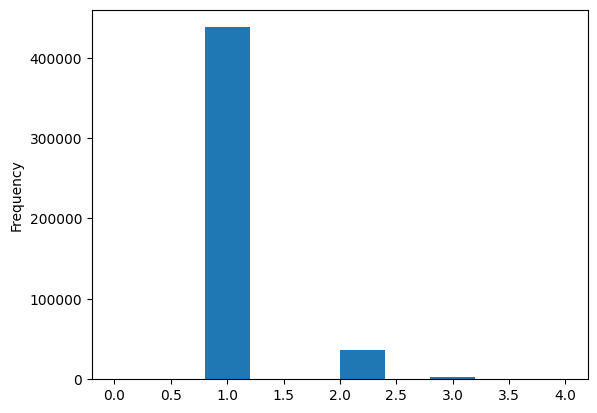

In [36]:
metrics_df['rank'].plot.hist(bins=10)

In [37]:
metrics_df.groupby('rank').count()

,u,v_pos,edge_type,ts,mrr,hits@1,hits@3,hits@10
rank,,,,,,,,
0.0,828,828,828,828,828,828,828,828
1.0,437829,437829,437829,437829,437829,437829,437829,437829
2.0,36076,36076,36076,36076,36076,36076,36076,36076
3.0,2661,2661,2661,2661,2661,2661,2661,2661
4.0,136,136,136,136,136,136,136,136


In [38]:
results = pd.read_csv("../data/transe/icews14/thesis-graph/fw3x91t3/train_val_0_scores.csv")
results

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,score,length
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0.000000,0
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0.000000,0
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0.000000,0
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0.000000,0
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,349797,5,6771,72,6711,0,0,7992,2,0,32,943,1.829789,5
42566,349798,5,5235,72,6196,0,0,7992,2,0,32,943,1.836058,5
42567,349799,44,5241,88,5917,0,0,7992,2,0,13,8,1.845275,5
42568,349800,44,2991,88,5587,0,0,7992,2,0,13,8,1.923808,4


In [39]:
len(results)

42570

In [40]:
len(results[results['label'] == 0])

25542

In [41]:
len(results[results['label'] == 1])

17028

In [42]:
results.iloc[0]

edge_id       307232.0
feat_pos_u         0.0
feat_pos_v        33.0
u                 44.0
v                211.0
u_type             0.0
v_type             0.0
ts              7296.0
split              2.0
label              1.0
edge_type          3.0
v_pos            211.0
score              0.0
length             0.0
Name: 0, dtype: float64

In [43]:
result_df = pd.DataFrame(results)
result_df

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,score,length
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0.000000,0
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0.000000,0
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0.000000,0
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0.000000,0
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,349797,5,6771,72,6711,0,0,7992,2,0,32,943,1.829789,5
42566,349798,5,5235,72,6196,0,0,7992,2,0,32,943,1.836058,5
42567,349799,44,5241,88,5917,0,0,7992,2,0,13,8,1.845275,5
42568,349800,44,2991,88,5587,0,0,7992,2,0,13,8,1.923808,4


In [44]:
result_df.describe()

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,score,length
count,42570.000000,42570.000000,42570.000000,42570.000000,42570.000000,42570.0,42570.0,42570.000000,42570.0,42570.000000,42570.000000,42570.000000,42570.000000,42570.000000
mean,328516.500000,537.759126,2360.519192,1124.978130,2563.367559,0.0,0.0,7645.099366,2.0,0.400000,70.126028,1021.909349,1.099306,2.598332
std,12289.044816,1042.529011,2290.092918,1699.161599,2258.919709,0.0,0.0,195.250129,0.0,0.489904,95.835064,1636.696323,0.939131,2.203067
min,307232.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7296.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,317874.250000,16.000000,159.000000,74.000000,407.000000,0.0,0.0,7488.000000,2.0,0.000000,9.000000,70.000000,0.000000,0.000000
50%,328516.500000,105.000000,1624.000000,372.000000,1990.500000,0.0,0.0,7656.000000,2.0,0.000000,25.000000,288.000000,1.827955,3.000000
75%,339158.750000,514.000000,4283.000000,1264.000000,4498.000000,0.0,0.0,7800.000000,2.0,1.000000,70.000000,1119.750000,1.918495,4.000000
max,349801.000000,7116.000000,7127.000000,6892.000000,7127.000000,0.0,0.0,7992.000000,2.0,1.000000,457.000000,6892.000000,1.976937,7.000000


In [45]:
result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

edge_id  feat_pos_u  feat_pos_v  v  u_type  v_type  \
u    v_pos edge_type ts                                                         
0    1     0         7536        4           4           4  4       4       4   
                     7560        4           4           4  4       4       4   
                     7608        4           4           4  4       4       4   
                     7680        4           4           4  4       4       4   
                     7728        4           4           4  4       4       4   
...                            ...         ...         ... ..     ...     ...   
6889 1115  231       7992        1           1           1  1       1       1   
6890 4363  3         7992        4           4           4  4       4       4   
           233       7992        1           1           1  1       1       1   
6891 53    12        7992        4           4           4  4       4       4   
6892 1897  18        7992        4           4           4  4       4       4   

                           split  label  score  length  
u    v_pos edge_type ts                                 
0    1     0         7536      4      4      4       4  
                     7560      4      4      4       4  
                     7608      4      4      4       4  
                     7680      4      4      4       4  
                     7728      4      4      4       4  
...                          ...    ...    ...     ...  
6889 1115  231       7992      1      1      1       1  
6890 4363  3         7992      4      4      4       4  
           233       7992      1      1      1       1  
6891 53    12        7992      4      4      4       4  
6892 1897  18        7992      4      4      4       4  

[17028 rows x 10 columns]

In [46]:
df.describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
count,9.834644e+06,9.834644e+06,9.834644e+06,9.834644e+06,9834644.0,9834644.0,9.834644e+06,9.834644e+06,9.834644e+06,9.834644e+06,9.834644e+06
mean,4.401120e+02,2.449317e+03,4.401120e+02,2.449317e+03,0.0,0.0,2.617267e+04,1.326192e+00,4.633426e-01,7.966768e+01,4.330827e+02
std,7.163919e+02,2.468838e+03,7.163919e+02,2.468838e+03,0.0,0.0,1.126094e+04,8.609914e-01,4.986545e-01,1.048941e+02,7.068992e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.200000e+01,1.980000e+02,5.200000e+01,1.980000e+02,0.0,0.0,1.695000e+04,1.000000e+00,0.000000e+00,7.000000e+00,5.200000e+01
50%,1.820000e+02,1.472000e+03,1.820000e+02,1.472000e+03,0.0,0.0,2.644500e+04,1.000000e+00,0.000000e+00,2.300000e+01,1.790000e+02
75%,5.120000e+02,4.555000e+03,5.120000e+02,4.555000e+03,0.0,0.0,3.538500e+04,2.000000e+00,1.000000e+00,1.090000e+02,5.040000e+02
max,7.690000e+03,7.690000e+03,7.690000e+03,7.690000e+03,0.0,0.0,4.462500e+04,3.000000e+00,1.000000e+00,4.790000e+02,7.690000e+03


In [47]:
df

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
edge_id,,,,,,,,,,,
0,0,1,0,1,0,0,0,0,1,0,1
1,2,3,2,3,0,0,0,0,1,1,3
2,4,3,4,3,0,0,0,0,1,2,3
3,5,3,5,3,0,0,0,0,1,3,3
4,6,3,6,3,0,0,0,0,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...
9834639,313,2570,313,2570,0,0,44625,3,0,7,21
9834640,313,7573,313,7573,0,0,44625,3,0,7,21
9834641,27,6876,27,6876,0,0,44625,3,0,31,2


In [48]:
test_df = pd.merge(df[df["split"] == 2], result_df, on=["u", "v_pos", "edge_type", "ts", "v", "label"])
test_df

,feat_pos_u_x,feat_pos_v_x,u,v,u_type_x,v_type_x,ts,split_x,label,edge_type,v_pos,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,score,length


In [49]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

,,,,feat_pos_u_x,feat_pos_v_x,v,u_type_x,v_type_x,split_x,label,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,score,length
u,v_pos,edge_type,ts,,,,,,,,,,,,,,,


In [50]:
test = result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()
test[test["v"] > 1]

edge_id  feat_pos_u  feat_pos_v  v  u_type  v_type  \
u    v_pos edge_type ts                                                         
0    1     0         7536        4           4           4  4       4       4   
                     7560        4           4           4  4       4       4   
                     7608        4           4           4  4       4       4   
                     7680        4           4           4  4       4       4   
                     7728        4           4           4  4       4       4   
...                            ...         ...         ... ..     ...     ...   
6883 607   9         7944        4           4           4  4       4       4   
6884 738   171       7968        4           4           4  4       4       4   
6890 4363  3         7992        4           4           4  4       4       4   
6891 53    12        7992        4           4           4  4       4       4   
6892 1897  18        7992        4           4           4  4       4       4   

                           split  label  score  length  
u    v_pos edge_type ts                                 
0    1     0         7536      4      4      4       4  
                     7560      4      4      4       4  
                     7608      4      4      4       4  
                     7680      4      4      4       4  
                     7728      4      4      4       4  
...                          ...    ...    ...     ...  
6883 607   9         7944      4      4      4       4  
6884 738   171       7968      4      4      4       4  
6890 4363  3         7992      4      4      4       4  
6891 53    12        7992      4      4      4       4  
6892 1897  18        7992      4      4      4       4  

[8514 rows x 10 columns]

In [51]:
from evaluation import evaluate
from collections import defaultdict

In [52]:
# edge_groups = defaultdict(lambda: {'pos_score': None, 'neg_scores': []})
# for item in results:
#     # Use v_pos as the target node for grouping, which is the true target for all edges
#     v_for_grouping = item.get('v_pos', item['v'])
#     key = (item['u'], item.get('edge_type'), v_for_grouping, item['ts'])
#     score = item['score']  # Now using the adjusted score
#     length = item['length']
    
#     if item['label'] == 1:
#         edge_groups[key]['pos_score'] = (score, length)
#     else:
#         edge_groups[key]['neg_scores'].append((score, length))

In [53]:
# final = evaluate(edge_groups, verbose=False)
final = evaluate(results, verbose=False)
final

({'rank': 0.25745830396993186,
  'mrr': 0.19572664630804168,
  'hits@1': 0.17952783650458068,
  'hits@3': 0.21300211416490486,
  'hits@10': 0.21441155743481324},
           u  v_pos  edge_type    ts  rank  mrr  hits@1  hits@3  hits@10
 0         0      1          0  7536   0.0  0.0     0.0     0.0      0.0
 1         0      1          0  7560   0.0  0.0     0.0     0.0      0.0
 2         0      1          0  7608   0.0  0.0     0.0     0.0      0.0
 3         0      1          0  7680   0.0  0.0     0.0     0.0      0.0
 4         0      1          0  7728   0.0  0.0     0.0     0.0      0.0
 ...     ...    ...        ...   ...   ...  ...     ...     ...      ...
 17023  6889   1115        231  7992   0.0  0.0     0.0     0.0      0.0
 17024  6890   4363          3  7992   0.0  0.0     0.0     0.0      0.0
 17025  6890   4363        233  7992   0.0  0.0     0.0     0.0      0.0
 17026  6891     53         12  7992   0.0  0.0     0.0     0.0      0.0
 17027  6892   1897         18  799

In [54]:
test_df

,feat_pos_u_x,feat_pos_v_x,u,v,u_type_x,v_type_x,ts,split_x,label,edge_type,v_pos,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,score,length


In [55]:
def process(group):
    return group.loc[group["label"] == 0, "length"].min()

In [56]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).apply(process, include_groups=False)

,,,,feat_pos_u_x,feat_pos_v_x,v,u_type_x,v_type_x,split_x,label,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,score,length
u,v_pos,edge_type,ts,,,,,,,,,,,,,,,


In [57]:
check = pd.merge(result_df, plot_df, on=["u", "v", "v_pos", "ts", "edge_type"])
check

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,score,length,path_length,label_y


In [58]:
check_df = check[check['length'] != check['path_length']]
check_df

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,score,length,path_length,label_y


In [59]:
check_df.describe()

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,score,length,path_length,label_y
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
